In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [2]:
import numpy as np
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import torch

from func2graph import data, baselines

activity shape:  (460, 5249)
neuron_ttypes shape:  460
connectivity shape:  (460, 460)


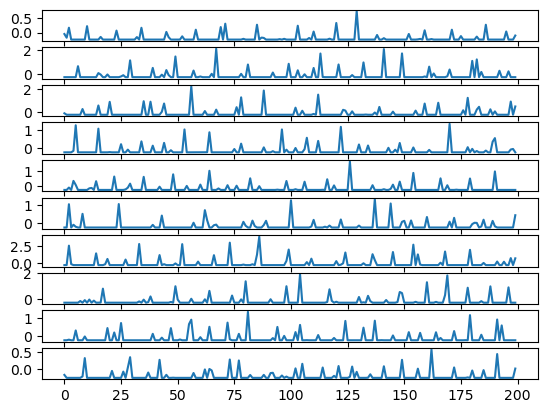

In [3]:
directory = '../../data/Mouse/Bugeon/'
date_exp = 'SB025/2019-10-07/'
input_setting = 'Blank/01/'

normalization = "session"    #####################################

activity, neuron_ttypes, connectivity = data.mouse_data_simulator(directory, date_exp, input_setting, normalization)

print('activity shape: ', activity.shape) 
print('neuron_ttypes shape: ', len(neuron_ttypes))
print('connectivity shape: ', connectivity.shape)

# plot activity
for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.plot(activity[i,:][:200])
plt.show()

max in activity:  77.772194
min in activity:  -0.24318177
mean in activity:  7.767982e-08
std in activity:  1.0000001
count how many values below 0:  2033612
count how many values equal 0:  0


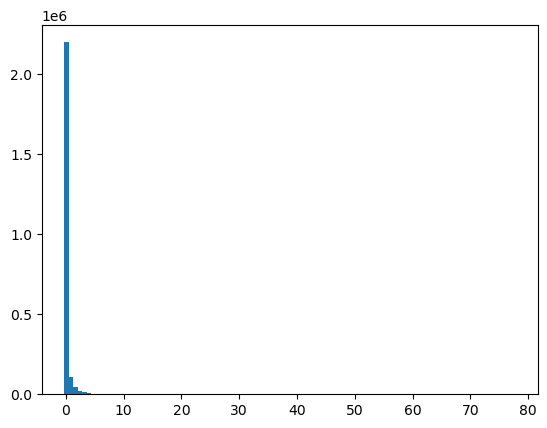

In [4]:
print('max in activity: ', np.max(activity))
print('min in activity: ', np.min(activity))
print('mean in activity: ', np.mean(activity))
print('std in activity: ', np.std(activity))

print('count how many values below 0: ', np.sum(activity<0))
print('count how many values equal 0: ', np.sum(activity==0))

# plot distribution of activity
plt.hist(activity.flatten(), bins=100)
plt.show()

### Useful functions

In [5]:
def group_correlation_matrix_by_cell_type(correlation_matrix, neuron_types):

    # Create an index of for each cell type, and also the list of cells (their original indices) in each cell type ###############
    
    cell_type2cell_type_index = {}
    cell_in_cell_type = {}
    cell_type_index2cell_type = {}
    cell_type_count = {}

    cell_type_index_count = 0
    for i in range(len(neuron_types)):
        # if cell type doesn't exist, add it to the order
        if neuron_types[i] not in cell_type2cell_type_index:
            cell_type2cell_type_index[neuron_types[i]] = cell_type_index_count
            cell_type_index_count += 1

        if neuron_types[i] not in cell_in_cell_type:
            cell_in_cell_type[neuron_types[i]] = [i]
        else:
            cell_in_cell_type[neuron_types[i]].append(i)

    for cell_type in cell_type2cell_type_index:
        cell_type_index2cell_type[cell_type2cell_type_index[cell_type]] = cell_type

    for cell_type in cell_type2cell_type_index:
        cell_type_count[cell_type] = len(cell_in_cell_type[cell_type])


    # print(cell_type2cell_type_index)
    # print(cell_in_cell_type)
    # print(cell_type_index2cell_type)
    # print(cell_type_count)


    # Create a new correlation matrix based on the cell type order #############################################################

    correlation_matrix_new = np.zeros((len(neuron_types), len(neuron_types)))

    current_cell_type_index_i = 0
    index_of_cell_in_cell_type_i = 0
    for i in range(len(neuron_types)):
        if index_of_cell_in_cell_type_i >= len(cell_in_cell_type[cell_type_index2cell_type[current_cell_type_index_i]]):
            current_cell_type_index_i += 1
            index_of_cell_in_cell_type_i = 0

        current_cell_type_i = cell_type_index2cell_type[current_cell_type_index_i]  

        # get the index of the cell in the original correlation matrix
        old_i = cell_in_cell_type[current_cell_type_i][index_of_cell_in_cell_type_i]  
        index_of_cell_in_cell_type_i += 1

        current_cell_type_index_j = 0
        index_of_cell_in_cell_type_j = 0
        for j in range(len(neuron_types)):
            if index_of_cell_in_cell_type_j >= len(cell_in_cell_type[cell_type_index2cell_type[current_cell_type_index_j]]):
                current_cell_type_index_j += 1
                index_of_cell_in_cell_type_j = 0

            current_cell_type_j = cell_type_index2cell_type[current_cell_type_index_j]

            # get the index of the cell in the original correlation matrix
            old_j = cell_in_cell_type[current_cell_type_j][index_of_cell_in_cell_type_j]
            index_of_cell_in_cell_type_j += 1

            correlation_matrix_new[i, j] = correlation_matrix[old_i, old_j]


    # Calculate the average correlation for each cell type ##################################################################

    correlation_matrix_cell_type_level = np.zeros((len(cell_type2cell_type_index), len(cell_type2cell_type_index)))

    accumulated_num_cells_i = 0
    for i in range(len(cell_type2cell_type_index)):
        old_i_start = accumulated_num_cells_i
        accumulated_num_cells_i += cell_type_count[cell_type_index2cell_type[i]]

        accumulated_num_cells_j = 0
        for j in range(len(cell_type2cell_type_index)):
            old_j_start = accumulated_num_cells_j
            accumulated_num_cells_j += cell_type_count[cell_type_index2cell_type[j]]

            # Remember to correct the denominator to be (total elements - # of cells in each cluster) when calculate for digonal elements
            num_elements_i = accumulated_num_cells_i - old_i_start
            num_elements_j = accumulated_num_cells_j - old_j_start
            total_num_elements = num_elements_i * num_elements_j
            if i == j:
                total_num_elements = total_num_elements - cell_type_count[cell_type_index2cell_type[i]]

            correlation_matrix_cell_type_level[i, j] = np.sum(correlation_matrix_new[old_i_start : accumulated_num_cells_i, old_j_start : accumulated_num_cells_j]) / total_num_elements

    return correlation_matrix_new, correlation_matrix_cell_type_level, cell_type2cell_type_index

In [6]:
print("neuron_ttypes: ", len(neuron_ttypes))
print(neuron_ttypes)

neuron_types_result = []
for i in range(len(neuron_ttypes)):
    # split by "-"
    neuron_types_result.append(neuron_ttypes[i].split("-")[0])
print(neuron_types_result)

neuron_ttypes:  460
['EC', 'IN', 'IN', 'Lamp5-Lsp1', 'EC', 'IN', 'EC', 'EC', 'IN', 'EC', 'EC', 'EC', 'IN', 'Pvalb-Tpbg', 'EC', 'EC', 'EC', 'Lamp5-Fam19a1-Pax6', 'EC', 'EC', 'EC', 'IN', 'EC', 'EC', 'IN', 'EC', 'IN', 'EC', 'EC', 'IN', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'IN', 'EC', 'EC', 'EC', 'EC', 'IN', 'IN', 'EC', 'IN', 'EC', 'IN', 'IN', 'EC', 'IN', 'Lamp5-Fam19a1-Pax6', 'EC', 'IN', 'IN', 'Lamp5-Fam19a1-Tmem182', 'IN', 'Lamp5-Lsp1', 'EC', 'EC', 'Vip-Igfbp4-Mab21l1', 'IN', 'IN', 'EC', 'Lamp5-Plch2-Dock5', 'EC', 'Lamp5-Plch2-Dock5', 'Lamp5-Fam19a1-Tmem182', 'IN', 'IN', 'EC', 'IN', 'Lamp5-Plch2-Dock5', 'IN', 'Lamp5-Lsp1', 'IN', 'EC', 'EC', 'Lamp5-Krt73', 'Lamp5-Fam19a1-Tmem182', 'EC', 'IN', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'IN', 'EC', 'EC', 'EC', 'EC', 'Lamp5-Fam19a1-Pax6', 'EC', 'IN', 'EC', 'Lamp5-Plch2-Dock5', 'Lamp5-Lsp1', 'EC', 'EC', 'EC', 'Lamp5-Fam19a1-Pax6', 'IN', 'Lamp5-Fam19a1-Pax6', 'Lamp5-Plch2-Dock5', 'EC', 'IN', 'Lamp5-Plch2-Dock5

### Calculate correlation between every pair of neurons

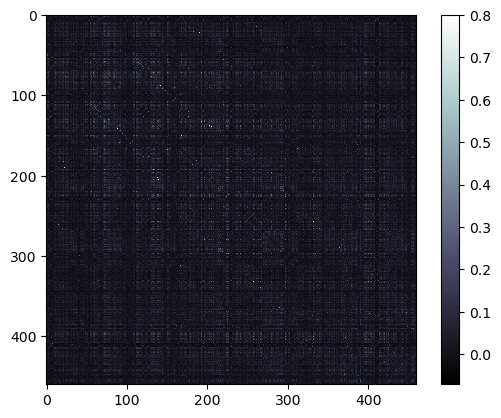

(460, 460)


In [7]:
correlation_matrix = baselines.get_activity_correlation_matrix(activity)

# make the diagonal elements to be 0
for i in range(correlation_matrix.shape[0]):
    correlation_matrix[i, i] = 0

# plot
plt.imshow(correlation_matrix, cmap='bone', interpolation='nearest')
plt.colorbar()
plt.show()

# correlation[np.isnan(correlation)] = 0
print(correlation_matrix.shape)

### Group predicted connectivity by cell types & Get cell-type level correlation matrix

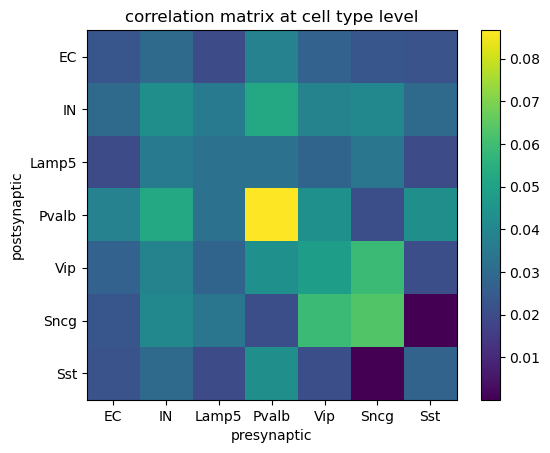

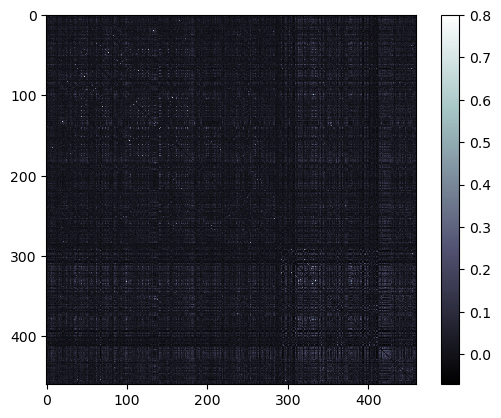

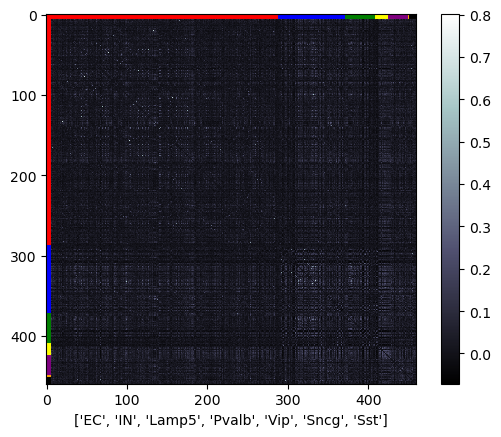

In [8]:
correlation_matrix_new, correlation_matrix_cell_type_level, cell_type2cell_type_index = group_correlation_matrix_by_cell_type(correlation_matrix, neuron_types_result)
cell_type_labels = cell_type2cell_type_index.keys()

plt.imshow(correlation_matrix_cell_type_level, interpolation='nearest')
plt.xticks(np.arange(len(cell_type_labels)), cell_type_labels)
plt.yticks(np.arange(len(cell_type_labels)), cell_type_labels)
plt.xlabel('presynaptic')
plt.ylabel('postsynaptic')
plt.title('correlation matrix at cell type level')
plt.colorbar()
plt.show()

plt.imshow(correlation_matrix_new, cmap='bone', interpolation='nearest')
plt.colorbar()
plt.show()

# plot
plt.imshow(correlation_matrix_new, cmap='bone', interpolation='nearest')
plt.colorbar()
plt.plot((0, 0), (0, 291), c='red', linewidth=5)
plt.plot((0, 291), (0, 0), c='red', linewidth=5)

plt.plot((0, 0), (291, 291+84), c='blue', linewidth=5)
plt.plot((291, 291+84), (0, 0), c='blue', linewidth=5)

plt.plot((0, 0), (291+84, 291+84+37), c='green', linewidth=5)
plt.plot((291+84, 291+84+37), (0, 0), c='green', linewidth=5)

plt.plot((0, 0), (291+84+37, 291+84+37+16), c='yellow', linewidth=5)
plt.plot((291+84+37, 291+84+37+16), (0, 0), c='yellow', linewidth=5)

plt.plot((0, 0), (291+84+37+16, 291+84+37+16+25), c='purple', linewidth=5)
plt.plot((291+84+37+16, 291+84+37+16+25), (0, 0), c='purple', linewidth=5)

plt.plot((0, 0), (291+84+37+16+25, 291+84+37+16+25+2), c='orange', linewidth=5)
plt.plot((291+84+37+16+25, 291+84+37+16+25+2), (0, 0), c='orange', linewidth=5)

plt.plot((0, 0), (291+84+37+16+25+2, 291+84+37+16+25+2+4), c='black', linewidth=5)
plt.plot((291+84+37+16+25+2, 291+84+37+16+25+2+4), (0, 0), c='black', linewidth=5)

# make x and y axis labels
cell_type_labels = list(cell_type2cell_type_index.keys())

plt.xlabel(str(cell_type_labels))
plt.show()

### Average correlation matrix across different segments
* Segment the whole activity 
* Get correlation matrix for all segments
* Take average of all


In [9]:
print('activity shape: ', activity.shape) 
print('neuron_ttypes shape: ', len(neuron_ttypes))
print('connectivity shape: ', connectivity.shape)

activity shape:  (460, 5249)
neuron_ttypes shape:  460
connectivity shape:  (460, 460)


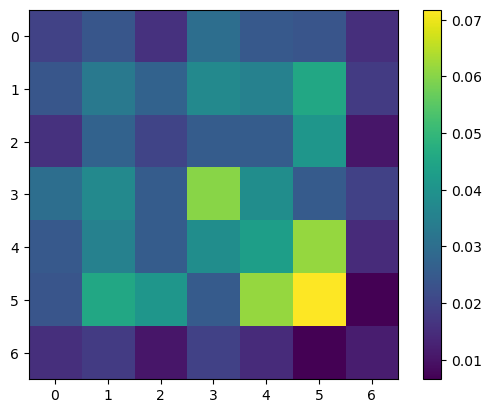

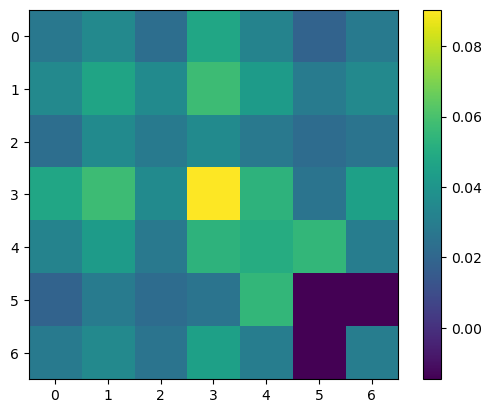

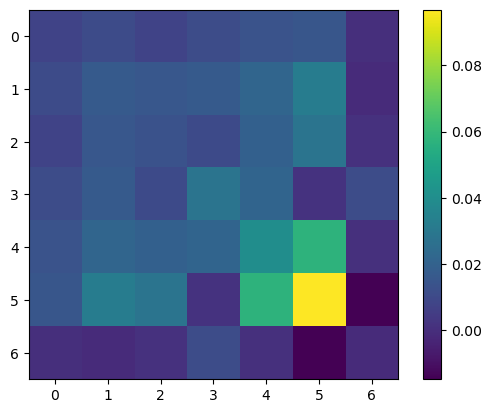

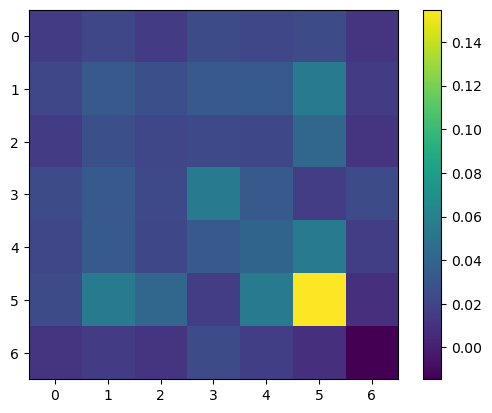

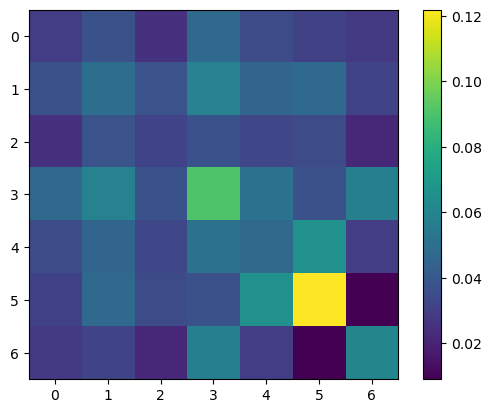

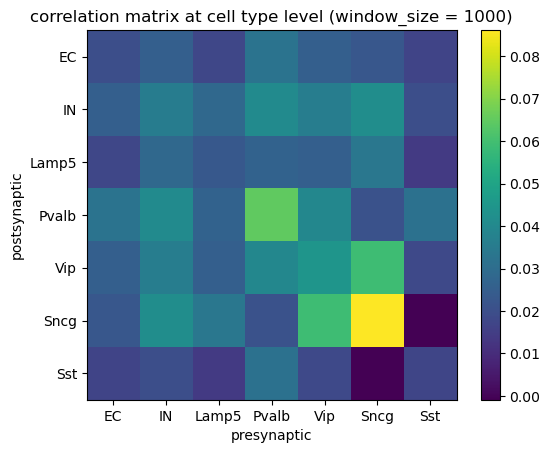

{'EC': 0, 'IN': 1, 'Lamp5': 2, 'Pvalb': 3, 'Vip': 4, 'Sncg': 5, 'Sst': 6}


In [56]:
fragment_size = 1000
num_fragments = activity.shape[1] // fragment_size

sum_cell_type_correlation_matrix = np.zeros((7, 7))

activity_fragmented = np.zeros((num_fragments, activity.shape[0], fragment_size))
for i in range(num_fragments):
    activity_fragmented[i, :, :] = activity[:, i*fragment_size : (i+1)*fragment_size]

    # get correlation matrix
    correlation_matrix = np.corrcoef(activity_fragmented[i, :, :])

    # make the diagonal elements to be 0
    for j in range(correlation_matrix.shape[0]):
        correlation_matrix[j, j] = 0

    # Get new correlation matrix and cell type level correlation matrix
    correlation_matrix_new, correlation_matrix_cell_type_level, cell_type2cell_type_index = group_correlation_matrix_by_cell_type(correlation_matrix, neuron_types_result)

    if i % np.trunc(num_fragments / 3) == 0:
        plt.imshow(correlation_matrix_cell_type_level, interpolation='nearest')
        plt.colorbar()
        plt.show()

    sum_cell_type_correlation_matrix += correlation_matrix_cell_type_level

sum_cell_type_correlation_matrix /= num_fragments

# print(sum_cell_type_correlation_matrix)

plt.imshow(sum_cell_type_correlation_matrix, interpolation='nearest')
# make x and y axis labels
cell_type_labels = cell_type2cell_type_index.keys()
plt.xticks(np.arange(len(cell_type_labels)), cell_type_labels)
plt.yticks(np.arange(len(cell_type_labels)), cell_type_labels)
plt.xlabel('presynaptic')
plt.ylabel('postsynaptic')
plt.title('correlation matrix at cell type level (window_size = ' + str(fragment_size) + ')')
plt.colorbar()
plt.show()

print(cell_type2cell_type_index)

### Manually plot groud truth connectivity

[[ 0.11   nan   nan -0.44 -0.06   nan -0.16]
 [  nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan]
 [ 0.27   nan   nan -0.47 -0.1    nan -0.18]
 [ 0.45   nan   nan -0.23 -0.1    nan -0.17]
 [  nan   nan   nan   nan   nan   nan   nan]
 [ 0.1    nan   nan -0.44 -0.17   nan -0.19]]


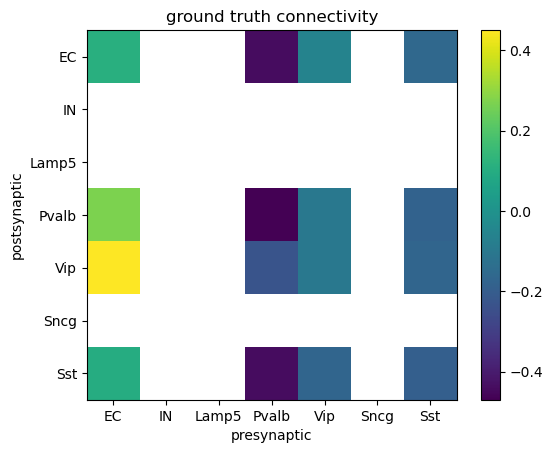

In [10]:
# make a matrix consisting of nan
ground_truth_connectivity = np.zeros((7, 7))
ground_truth_connectivity[:] = np.nan

# ground_truth_connectivity[cell_type2cell_type_index['EC']][cell_type2cell_type_index['EC']] = 13/229
# ground_truth_connectivity[cell_type2cell_type_index['Pvalb']][cell_type2cell_type_index['EC']] = 22/53
# ground_truth_connectivity[cell_type2cell_type_index['Sst']][cell_type2cell_type_index['EC']]= 20/67
# ground_truth_connectivity[cell_type2cell_type_index['Vip']][cell_type2cell_type_index['EC']] = 11/68

# ground_truth_connectivity[cell_type2cell_type_index['EC']][cell_type2cell_type_index['Pvalb']] = 18/52
# ground_truth_connectivity[cell_type2cell_type_index['Pvalb']][cell_type2cell_type_index['Pvalb']] = 45/114
# ground_truth_connectivity[cell_type2cell_type_index['Sst']][cell_type2cell_type_index['Pvalb']] = 8/88
# ground_truth_connectivity[cell_type2cell_type_index['Vip']][cell_type2cell_type_index['Pvalb']] = 0/54

# ground_truth_connectivity[cell_type2cell_type_index['EC']][cell_type2cell_type_index['Sst']] = 13/56
# ground_truth_connectivity[cell_type2cell_type_index['Pvalb']][cell_type2cell_type_index['Sst']] = 15/84
# ground_truth_connectivity[cell_type2cell_type_index['Sst']][cell_type2cell_type_index['Sst']] = 8/154
# ground_truth_connectivity[cell_type2cell_type_index['Vip']][cell_type2cell_type_index['Sst']] = 25/84

# ground_truth_connectivity[cell_type2cell_type_index['EC']][cell_type2cell_type_index['Vip']] = 3/62
# ground_truth_connectivity[cell_type2cell_type_index['Pvalb']][cell_type2cell_type_index['Vip']] = 1/54
# ground_truth_connectivity[cell_type2cell_type_index['Sst']][cell_type2cell_type_index['Vip']] = 12/87
# ground_truth_connectivity[cell_type2cell_type_index['Vip']][cell_type2cell_type_index['Vip']] = 2/209

correct_cell_type2id = cell_type2cell_type_index
# ground_truth_connectivity[correct_cell_type2id['EC']][correct_cell_type2id['EC']] = 0.3
# ground_truth_connectivity[correct_cell_type2id['Pvalb']][correct_cell_type2id['EC']] = 0.59
# ground_truth_connectivity[correct_cell_type2id['Sst']][correct_cell_type2id['EC']]= 0.88
# ground_truth_connectivity[correct_cell_type2id['Vip']][correct_cell_type2id['EC']] = 1.89

# ground_truth_connectivity[correct_cell_type2id['EC']][correct_cell_type2id['Pvalb']] = -0.43
# ground_truth_connectivity[correct_cell_type2id['Pvalb']][correct_cell_type2id['Pvalb']] = -0.53
# ground_truth_connectivity[correct_cell_type2id['Sst']][correct_cell_type2id['Pvalb']] = -0.60
# ground_truth_connectivity[correct_cell_type2id['Vip']][correct_cell_type2id['Pvalb']] = -0.44

# ground_truth_connectivity[correct_cell_type2id['EC']][correct_cell_type2id['Sst']] = -0.31
# ground_truth_connectivity[correct_cell_type2id['Pvalb']][correct_cell_type2id['Sst']] = -0.43
# ground_truth_connectivity[correct_cell_type2id['Sst']][correct_cell_type2id['Sst']] = -0.43
# ground_truth_connectivity[correct_cell_type2id['Vip']][correct_cell_type2id['Sst']] = -0.79

# ground_truth_connectivity[correct_cell_type2id['EC']][correct_cell_type2id['Vip']] = -0.25
# ground_truth_connectivity[correct_cell_type2id['Pvalb']][correct_cell_type2id['Vip']] = -0.30
# ground_truth_connectivity[correct_cell_type2id['Sst']][correct_cell_type2id['Vip']] = -0.42
# ground_truth_connectivity[correct_cell_type2id['Vip']][correct_cell_type2id['Vip']] = -0.33

ground_truth_connectivity[correct_cell_type2id['EC']][correct_cell_type2id['EC']] = 0.11
ground_truth_connectivity[correct_cell_type2id['Pvalb']][correct_cell_type2id['EC']] = 0.27
ground_truth_connectivity[correct_cell_type2id['Sst']][correct_cell_type2id['EC']]= 0.1
ground_truth_connectivity[correct_cell_type2id['Vip']][correct_cell_type2id['EC']] = 0.45

ground_truth_connectivity[correct_cell_type2id['EC']][correct_cell_type2id['Pvalb']] = -0.44
ground_truth_connectivity[correct_cell_type2id['Pvalb']][correct_cell_type2id['Pvalb']] = -0.47
ground_truth_connectivity[correct_cell_type2id['Sst']][correct_cell_type2id['Pvalb']] = -0.44
ground_truth_connectivity[correct_cell_type2id['Vip']][correct_cell_type2id['Pvalb']] = -0.23

ground_truth_connectivity[correct_cell_type2id['EC']][correct_cell_type2id['Sst']] = -0.16
ground_truth_connectivity[correct_cell_type2id['Pvalb']][correct_cell_type2id['Sst']] = -0.18
ground_truth_connectivity[correct_cell_type2id['Sst']][correct_cell_type2id['Sst']] = -0.19
ground_truth_connectivity[correct_cell_type2id['Vip']][correct_cell_type2id['Sst']] = -0.17

ground_truth_connectivity[correct_cell_type2id['EC']][correct_cell_type2id['Vip']] = -0.06
ground_truth_connectivity[correct_cell_type2id['Pvalb']][correct_cell_type2id['Vip']] = -0.10
ground_truth_connectivity[correct_cell_type2id['Sst']][correct_cell_type2id['Vip']] = -0.17
ground_truth_connectivity[correct_cell_type2id['Vip']][correct_cell_type2id['Vip']] = -0.10

print(ground_truth_connectivity)

# plot
plt.imshow(ground_truth_connectivity, interpolation='nearest')
plt.xticks(np.arange(len(cell_type_labels)), cell_type_labels)
plt.yticks(np.arange(len(cell_type_labels)), cell_type_labels)
plt.xlabel('presynaptic')
plt.ylabel('postsynaptic')
plt.title('ground truth connectivity')
plt.colorbar()

# add some cells to grey color
plt.show()

### Get correlation between correlation matrix and estimated W from baseline 2

correlation between correlation matrix and estimated W:  0.41108858576289653


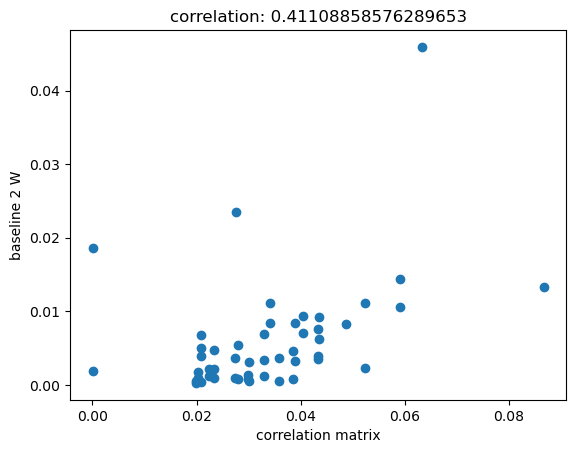

correlation between attention W and estimated W:  0.6855139610120415


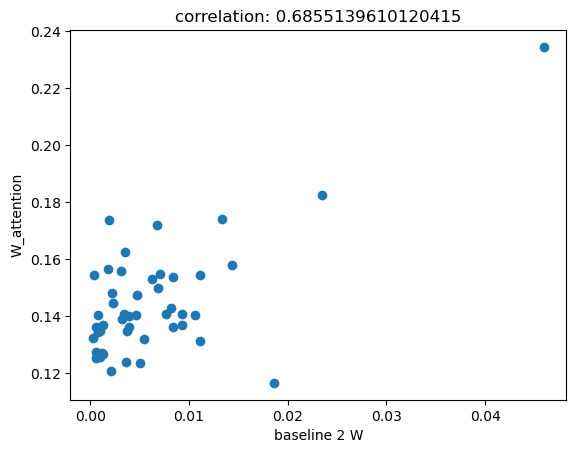

correlation between correlation matrix and W_attention:  0.3999659647621925


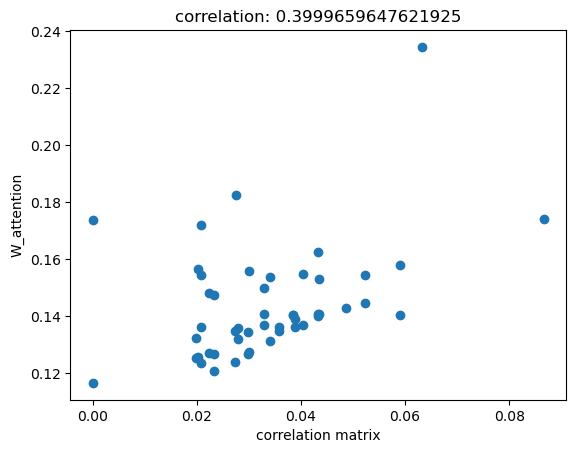

In [13]:
estimated_W_baseline2 = np.load('../../output/10_22_Baseline_2_Mouse_tanh/Baseline_2_mouse_session_460_0.8_200_baseline_2_100_42_1_1_64_258_2_5e-05_none_128_2_5/Estimated_W_cell_type_level.npy')
estimated_W_baseline2 = np.abs(estimated_W_baseline2)

# get correlation
corr = stats.pearsonr(correlation_matrix_cell_type_level.flatten(), estimated_W_baseline2.flatten())[0]
print('correlation between correlation matrix and estimated W: ', corr)

# plot
plt.plot(correlation_matrix_cell_type_level.flatten(), estimated_W_baseline2.flatten(), 'o')
plt.xlabel('correlation matrix')
plt.ylabel('baseline 2 W')
plt.title('correlation: ' + str(corr))
plt.show()

W_attention = np.load('../../output/10_29_Attention_Mouse_predict_log_poisson_sigmoid/Attention_Autoencoder_mouse_log_460_0.8_20_prediction_1_62_1_1_100_64_0_0.0001_lookup_table_128_2_5_poisson/Estimated_W_cell_type_level.npy')

# get correlation
corr = stats.pearsonr(estimated_W_baseline2.flatten(), W_attention.flatten())[0]
print('correlation between attention W and estimated W: ', corr)

# plot
plt.plot(estimated_W_baseline2.flatten(), W_attention.flatten(), 'o')
plt.xlabel('baseline 2 W')
plt.ylabel('W_attention')
plt.title('correlation: ' + str(corr))
plt.show()

# get correlation
corr = stats.pearsonr(correlation_matrix_cell_type_level.flatten(), W_attention.flatten())[0]
print('correlation between correlation matrix and W_attention: ', corr)

# plot
plt.plot(correlation_matrix_cell_type_level.flatten(), W_attention.flatten(), 'o')
plt.xlabel('correlation matrix')
plt.ylabel('W_attention')
plt.title('correlation: ' + str(corr))
plt.show()

pearson corr:  -0.4716972136465264
spearman corr:  -0.3843312210120439
pearson corr abs:  0.3207880463538208


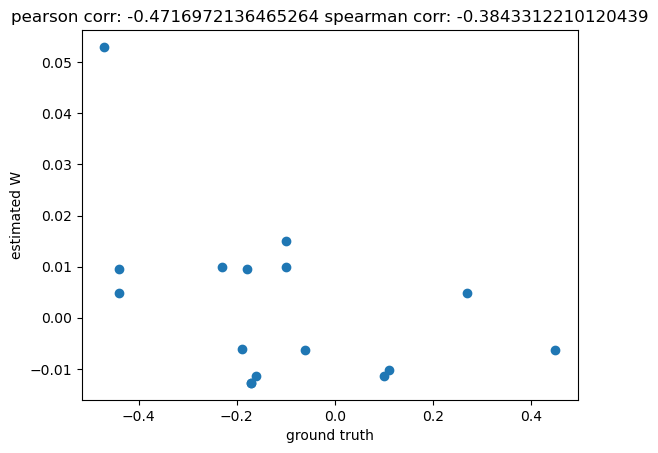

(16,)
(16,)


In [17]:
# compute correlation between ground truth and estimated W
# remove nan

# prediction = np.load('../../output/10_29_Attention_Mouse_predict_log_poisson_sigmoid/Attention_Autoencoder_mouse_log_460_0.8_20_prediction_1_42_1_1_20_64_0_0.001_lookup_table_128_2_5_poisson/Estimated_W_cell_type_level.npy')
# prediction = estimated_W_baseline2
prediction = correlation_matrix_cell_type_level
# make prediction center around 0
prediction = prediction - np.mean(prediction)

estimated_W = prediction[~np.isnan(ground_truth_connectivity)]

# corr
pearson_corr = stats.pearsonr(ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].flatten(), estimated_W.flatten())[0]
print('pearson corr: ', pearson_corr)

spearman_corr = stats.spearmanr(ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].flatten(), estimated_W.flatten())[0]
print('spearman corr: ', spearman_corr)

pearson_corr_abs = stats.pearsonr(np.abs(ground_truth_connectivity[~np.isnan(ground_truth_connectivity)]).flatten(), np.abs(estimated_W.flatten()))[0]
print('pearson corr abs: ', pearson_corr_abs)

# plot
plt.plot(ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].flatten(), estimated_W.flatten(), 'o')
plt.xlabel('ground truth')
plt.ylabel('estimated W')
plt.title('pearson corr: ' + str(pearson_corr) + ' spearman corr: ' + str(spearman_corr))
plt.show()

print(estimated_W.shape)
print(ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].shape)

#### Ensemble attention matrix

pearson corr:  0.0017679585033651413
spearman corr:  -0.09999999999999999


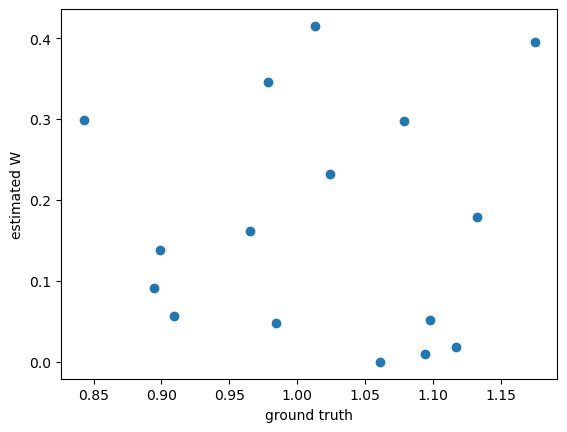

In [106]:
attention_1 = np.load('../../output/10_29_Attention_Mouse_predict_log_poisson_sigmoid_key100/Attention_Autoencoder_mouse_log_460_0.8_20_prediction_1_12_1_1_100_64_0_0.001_lookup_table_128_2_5_poisson/Estimated_W_cell_type_level.npy')
attention_2 = np.load('../../output/10_29_Attention_Mouse_predict_log_poisson_sigmoid_key100/Attention_Autoencoder_mouse_log_460_0.8_20_prediction_1_22_1_1_100_64_0_0.001_lookup_table_128_2_5_poisson/Estimated_W_cell_type_level.npy')
attention_3 = np.load('../../output/10_29_Attention_Mouse_predict_log_poisson_sigmoid_key100/Attention_Autoencoder_mouse_log_460_0.8_20_prediction_1_32_1_1_100_64_0_0.001_lookup_table_128_2_5_poisson/Estimated_W_cell_type_level.npy')
attention_4 = np.load('../../output/10_29_Attention_Mouse_predict_log_poisson_sigmoid_key100/Attention_Autoencoder_mouse_log_460_0.8_20_prediction_1_42_1_1_100_64_0_0.001_lookup_table_128_2_5_poisson/Estimated_W_cell_type_level.npy')
prediction = attention_1 + attention_2 + attention_3 + attention_4


pearson_corr = stats.pearsonr(prediction[~np.isnan(ground_truth_connectivity)].flatten(), ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].flatten())[0]
print('pearson corr: ', pearson_corr)

spearman_corr = stats.spearmanr(prediction[~np.isnan(ground_truth_connectivity)].flatten(), ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].flatten())[0]
print('spearman corr: ', spearman_corr)

# plot
plt.plot(prediction[~np.isnan(ground_truth_connectivity)].flatten(), ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].flatten(), 'o')
plt.xlabel('ground truth')
plt.ylabel('estimated W')
plt.show()

### Baseline LOSS

#### take average of history activity to be the prediction for next activity

In [6]:
window_size = 20 # -------------------------------
split_ratio = 0.8
task_type = "prediction"    # "reconstruction" or "prediction" or "baseline_2" or "mask"
predict_window_size = 1
data_type = "mouse" 

normalization = "session"   # "neuron" or "session" or "none" or "log"
if normalization == "log":
    log_input = True
else:
    log_input = False

loss_function = "guassian"                # "mse" or "poisson" or "guassian"

train_dataloader, val_dataloader, connectivity, neuron_ttypes = data.generate_simulation_data(
    window_size=window_size, 
    split_ratio=split_ratio,
    task_type=task_type,
    predict_window_size=predict_window_size,
    data_type=data_type,
    normalization=normalization
)

# take average of history activity to be the prediction for next activity
avg_loss = []
for val_x, val_y in val_dataloader:
    val_x = val_x.numpy()
    val_y = val_y.numpy().reshape(val_y.shape[0], -1)
    # get the average of history activity
    val_y_pred = np.mean(val_x, axis=2)
    print(val_y_pred.shape)

    # get LOSS
    if loss_function == "mse":
        loss = np.mean((val_y_pred - val_y)**2)
    elif loss_function == "poisson":
        loss_func = torch.nn.PoissonNLLLoss(reduction='mean', log_input=log_input)
        loss = loss_func(torch.from_numpy(val_y_pred), torch.from_numpy(val_y))
    elif loss_function == "guassian":
        loss_func = torch.nn.GaussianNLLLoss(reduction='mean')
        var = torch.ones(val_y_pred.shape)
        loss = loss_func(torch.from_numpy(val_y_pred), torch.from_numpy(val_y), var)
        
    print('loss: ', loss)
    avg_loss.append(loss)

print('average loss: ', np.mean(avg_loss))

torch.Size([460, 5249])
val_data.shape:  torch.Size([1031, 460, 20])
tensor([[-0.2432, -0.2432, -0.2432,  ..., -0.0852, -0.2432, -0.2432],
        [-0.2432, -0.2432, -0.2432,  ..., -0.2432,  1.8518, -0.2432],
        [-0.2432, -0.2432, -0.2432,  ..., -0.2432, -0.2432, -0.2432],
        ...,
        [-0.2432, -0.2432, -0.2432,  ..., -0.2432, -0.2432, -0.2432],
        [-0.2432, -0.2432, -0.2432,  ..., -0.2432, -0.2432, -0.2432],
        [ 0.2952, -0.2432, -0.2432,  ..., -0.2432, -0.0792,  1.5077]])
(32, 460)
loss:  tensor(0.4574)
(32, 460)
loss:  tensor(0.4225)
(32, 460)
loss:  tensor(0.3502)
(32, 460)
loss:  tensor(0.7124)
(32, 460)
loss:  tensor(0.4729)
(32, 460)
loss:  tensor(0.4477)
(32, 460)
loss:  tensor(0.5620)
(32, 460)
loss:  tensor(0.4838)
(32, 460)
loss:  tensor(0.8416)
(32, 460)
loss:  tensor(0.5541)
(32, 460)
loss:  tensor(0.8345)
(32, 460)
loss:  tensor(0.6481)
(32, 460)
loss:  tensor(0.4114)
(32, 460)
loss:  tensor(0.4169)
(32, 460)
loss:  tensor(0.3013)
(32, 460)
loss:  

In [6]:
# try ensemble

correct_cell_type2id = {'IN':0, 'Vip':1, 'Sncg':2, 'Sst':3, 'EC':4, 'Lamp5':5, 'Serpinf1':6, 'Pvalb':7}
correct_id2cell_type = {v: k for k, v in correct_cell_type2id.items()}
cell_type = [correct_id2cell_type.get(i) for i in range(len(correct_cell_type2id))]

# Make the ground truth connectivity matrix
ground_truth_connectivity = np.zeros((8, 8))
ground_truth_connectivity[:] = np.nan

ground_truth_connectivity[correct_cell_type2id['EC']][correct_cell_type2id['EC']] = 13/229
ground_truth_connectivity[correct_cell_type2id['Pvalb']][correct_cell_type2id['EC']] = 22/53
ground_truth_connectivity[correct_cell_type2id['Sst']][correct_cell_type2id['EC']]= 20/67
ground_truth_connectivity[correct_cell_type2id['Vip']][correct_cell_type2id['EC']] = 11/68

ground_truth_connectivity[correct_cell_type2id['EC']][correct_cell_type2id['Pvalb']] = 18/52
ground_truth_connectivity[correct_cell_type2id['Pvalb']][correct_cell_type2id['Pvalb']] = 45/114
ground_truth_connectivity[correct_cell_type2id['Sst']][correct_cell_type2id['Pvalb']] = 8/88
ground_truth_connectivity[correct_cell_type2id['Vip']][correct_cell_type2id['Pvalb']] = 0/54

ground_truth_connectivity[correct_cell_type2id['EC']][correct_cell_type2id['Sst']] = 13/56
ground_truth_connectivity[correct_cell_type2id['Pvalb']][correct_cell_type2id['Sst']] = 15/84
ground_truth_connectivity[correct_cell_type2id['Sst']][correct_cell_type2id['Sst']] = 8/154
ground_truth_connectivity[correct_cell_type2id['Vip']][correct_cell_type2id['Sst']] = 25/84

ground_truth_connectivity[correct_cell_type2id['EC']][correct_cell_type2id['Vip']] = 3/62
ground_truth_connectivity[correct_cell_type2id['Pvalb']][correct_cell_type2id['Vip']] = 1/54
ground_truth_connectivity[correct_cell_type2id['Sst']][correct_cell_type2id['Vip']] = 12/87
ground_truth_connectivity[correct_cell_type2id['Vip']][correct_cell_type2id['Vip']] = 2/209

# get attentions

attention_1 = np.load('../../output/11_4_mouse_AWC_sigmoid/Attention_With_Constraint_32_200_1_session_12_128_2_1_1_128_128_2_0.2_1e-05_mse_1.0/k_k.npy')
attention_2 = np.load('../../output/11_4_mouse_AWC_sigmoid/Attention_With_Constraint_32_200_1_session_22_128_2_1_1_128_128_2_0.2_1e-05_mse_1.0/k_k.npy')
attention_3 = np.load('../../output/11_4_mouse_AWC_sigmoid/Attention_With_Constraint_32_200_1_session_32_128_2_1_1_128_128_2_0.2_1e-05_mse_1.0/k_k.npy')
attention_4 = np.load('../../output/11_4_mouse_AWC_sigmoid/Attention_With_Constraint_32_200_1_session_42_128_2_1_1_128_128_2_0.2_1e-05_mse_1.0/k_k.npy')

# get average attention
attention = (-1*attention_1 + attention_2 + attention_4)
corr = stats.pearsonr(attention[~np.isnan(ground_truth_connectivity)].flatten(), ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].flatten())[0]
print('pearson corr: ', corr)

pearson corr:  0.373733924574495
